In [ ]:
# Plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# Data and numerics
import pandas as pd
import numpy as np
import scipy as scp

# System
import os 
from datetime import datetime
import sys

# Utilities
import yaml
from itertools import product
import pickle
import uuid

# Tensorflow
import tensorflow as tf
from tensorflow import keras

# Own
#import make_data_wfpt as mdw
import cddm_data_simulation as cds
import boundary_functions as bf
import kde_training_utilities as kde_utils
import kde_class as kdec

In [ ]:
# Predict
def mlp_manifold(params = [],
                 vary_idx = [],
                 vary_range = [],
                 vary_name = [],
                 n_levels = 25,
                 network_dir = [],
                 save = True,
                 show = True,
                 title = 'MLP Manifold',
                 model = 'ddm',
                ):

    # Load Keras model and initialize batch container
    keras_model = keras.models.load_model(network_dir + 'model_final.h5')

    # Prepare data structures
    # Data template
    plot_data = np.zeros((4000, 2))
    plot_data[:, 0] = np.concatenate(([i * 0.005 for i in range(2000, 0, -1)], [i * 0.005 for i in range(1, 2001, 1)]))
    plot_data[:, 1] = np.concatenate((np.repeat(-1, 2000), np.repeat(1, 2000)))

    data_var = np.zeros((4000 * n_levels, len(params) + 3))

    cnt = 0 
    for par_tmp in np.linspace(vary_range[0], vary_range[1], n_levels):
        tmp_begin = 4000 * cnt
        tmp_end = 4000 * (cnt + 1)
        params[vary_idx] = par_tmp
        data_var[tmp_begin:tmp_end, :len(params)] = params
        data_var[tmp_begin:tmp_end, len(params):(len(params) + 2)] = plot_data
        data_var[tmp_begin:tmp_end, (len(params) + 2)] = np.squeeze(np.exp(keras_model.predict(data_var[tmp_begin:tmp_end, :-1])))
        cnt += 1

    plt.rcParams['figure.figsize'] = [15.0, 10.0]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.plot_trisurf(data_var[:, -2] * data_var[:, -3], 
                    data_var[:, vary_idx], 
                    data_var[:, -1], 
                    linewidth = 0.2, 
                    alpha = 0.5, 
                    cmap = plt.cm.magma)
    
    ax.set_ylabel(vary_name.upper(),  
                  fontsize = 20, 
                  labelpad = 20)
    
    ax.set_xlabel('RT',  
                  fontsize = 20, 
                  labelpad = 20)
    
    ax.set_zlabel('Likelihood',  
                  fontsize = 20, 
                  labelpad = 20)
    
    ax.set_zticks(np.round(np.linspace(min(data_var[:, -1]), 
                                       max(data_var[:, -1]), 
                                       5), 
                                1))

    ax.set_yticks(np.round(np.linspace(min(data_var[:, vary_idx]), 
                                       max(data_var[:, vary_idx]), 
                                       5),
                                1))

    ax.set_xticks(np.round(np.linspace(min(data_var[:, -2] * data_var[:, -3]), 
                                       max(data_var[:, -2] * data_var[:, -3]), 
                                       5), 
                                1))
    
    ax.tick_params(labelsize = 16)
    ax.set_title(model.upper() + ' - MLP: Manifold', 
                 fontsize = 24, 
                 pad = 20)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    plt.savefig('./figures/mlp_manifolds/mlp_manifold_' + model + '_vary_' + vary_name + '.png', 
                bbox_inches = 'tight',
                dpi = 150)
    if show:
        plt.show()

In [ ]:
# INITIALIZATIONS -------------------------------------------------------------
# INSERT HERE
machine = 'home' # put custom if you want to keep your network_path
model = 'ddm'

if machine == 'x7':
    stats = pickle.load(open("/media/data_cifs/afengler/git_repos/nn_likelihoods/kde_stats.pickle", "rb"))
    model_params = stats[model]
    output_folder = model_params['output_folder_x7']
    with open("model_paths_x7.yaml") as tmp_file:
        network_path = yaml.load(tmp_file)[model]
if machine == 'ccv':
    stats = pickle.load(open("/users/afengler/git_repos/nn_likelihoods/kde_stats.pickle", "rb"))
    model_params = stats[model]
    output_folder = model_params['output_folder']
    with open("model_paths.yaml") as tmp_file:
        network_path = yaml.load(tmp_file)[model]
if machine == 'home':
    stats = pickle.load(open("/users/afengler/OneDrive/git_repos/nn_likelihoods/kde_stats.pickle", "rb"))
    model_params = stats[model]
    output_folder = model_params['output_folder']
    with open("model_paths_home.yaml") as tmp_file:
        network_path = yaml.load(tmp_file)[model]

0
1
2
3


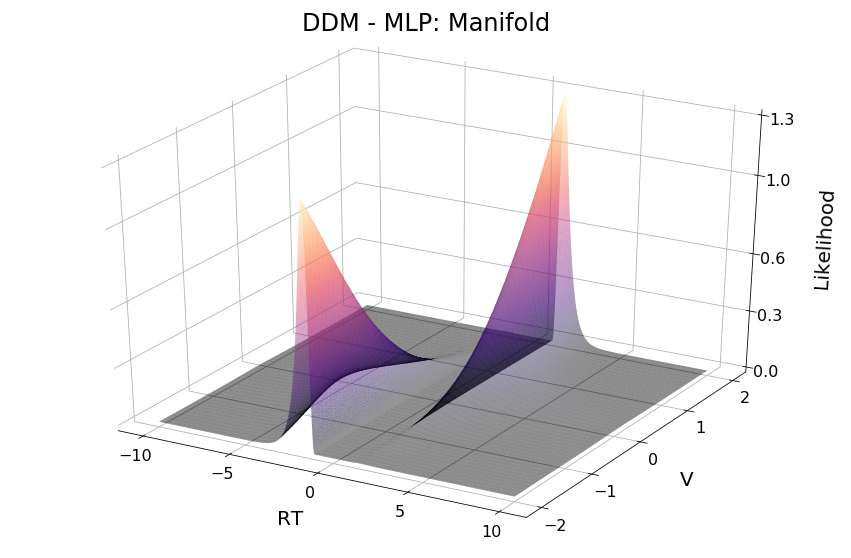

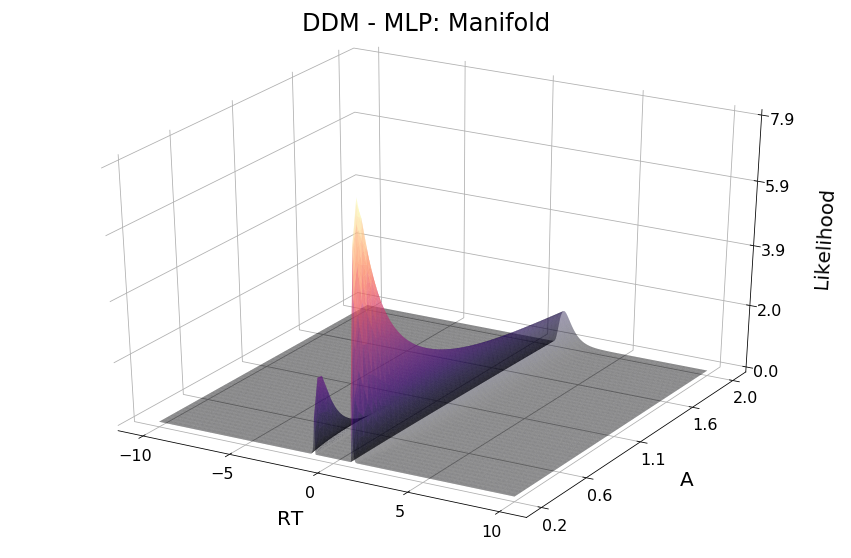

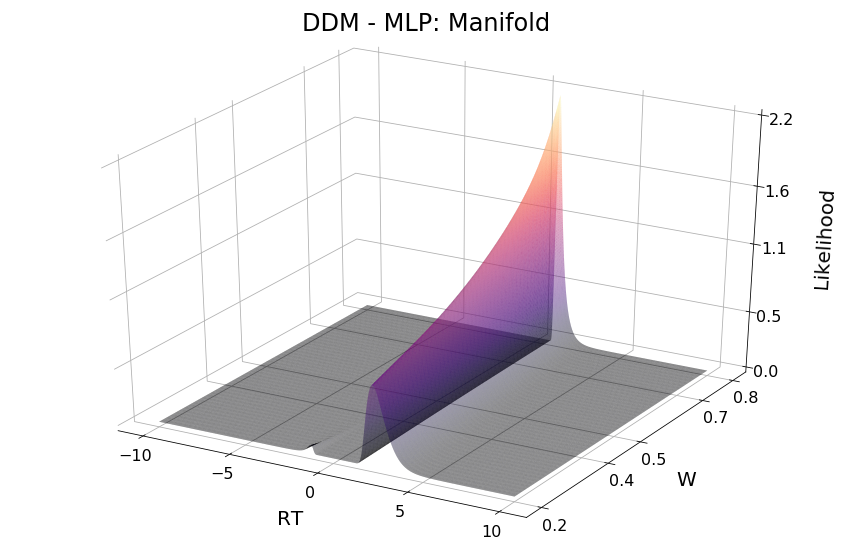

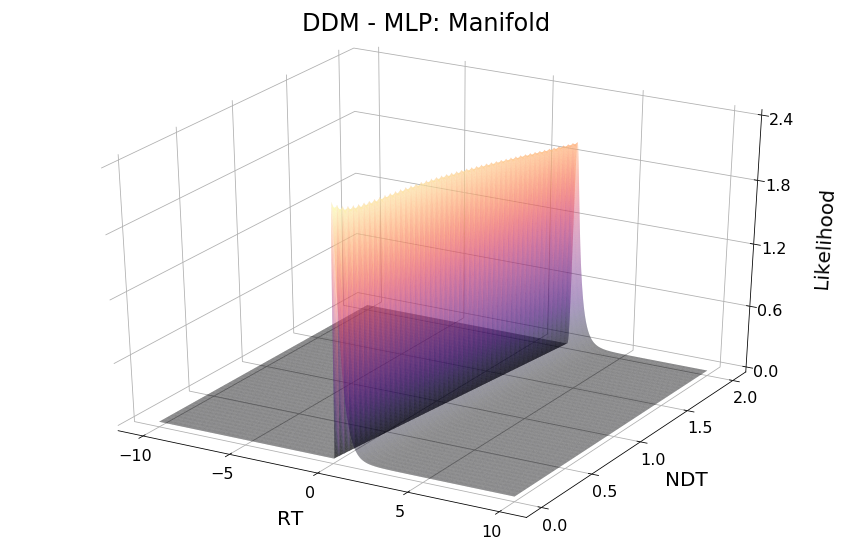

In [97]:
vary_idx_vec = [0, 1, 2, 3]
params = [0, 1.5, 0.5, 1]
vary_range_vec = [[-2, 2], [0.2, 2], [0.2, 0.8], [0, 2]]
vary_name_vec = ['v', 'a', 'w', 'ndt']
n_levels = 50

for i in range(len(params)):
    print(i)
    mlp_manifold(params = params,
                 vary_idx = vary_idx_vec[i],
                 vary_range = vary_range_vec[i],
                 vary_name = vary_name_vec[i],
                 n_levels = n_levels,
                 network_dir = network_path,
                 save = True,
                 show = False,
                 title = 'MLP Manifold')